In [270]:
import numpy as np
import ngsolve as ng
import matplotlib.pyplot as plt
from ngsolve.webgui import Draw
from netgen.occ import Circle, OCCGeometry, Pnt, Segment, Wire, Face
from ngsolve_special_functions import jv, hankel1

## Helmholtz Problem

We consider the boundary value problem:

$$
\begin{cases}
\Delta u + k^2 u = 0 & \text{in } \Omega_N = B_N \setminus \Omega, \\
u = f & \text{on } \Gamma = \partial \Omega, \\
\dfrac{\partial u}{\partial n} = g & \text{on } S_N = \partial B_N.
\end{cases}
$$

where

$$
B_N = \{(x, y) \in \mathbb{R}^2 : x^2 + y^2 < r\}, \quad (r > 1),
$$  

and $\Omega \subset \mathbb{R}^2$ is the polygonal domain with vertices

$$
(x_j, y_j) = r_j (\cos \theta_j, \sin \theta_j), \quad \theta_j = \frac{2\pi}{10}(j-2),
$$  

$$
r_{2j-1} = 1, \quad r_{2j} = \tfrac{1}{2}, \quad j = 1, \ldots, 10.
$$

---

### Variational Formulation

We consider the space
  $$
  V := \mathring H^1(\Omega_N) = \{\, v \in H^1(\Omega_N) : \gamma_\Gamma v = 0 \,\}.
  $$

where $\gamma_\Gamma$ denotes the trace operator on $\Gamma$. Next, we define 
$a: V \times V \mapsto \mathbb{K}$ amd $\ell: V \mapsto \mathbb{K}$

$$
a(u,v) := -\int_{\Omega_N} \nabla u \cdot \nabla v \, dx + k^2 \int_{\Omega_N} u\,v \, dx,
$$

$$
\ell(v) := -\int_{S_N} g \, \gamma_{S_N} v \, ds.
$$

This way, we obtain the variational formulation for the case of an homogeneous Dirichlet 
boundary condition over $\Gamma$, i.e. when $f=0$: Find $u \in V$ s.t.

$$
a(u,v) = \ell(v) \qquad \forall v \in V.
$$

Now, since we want allow the Dirichlet condition over $\Gamma$ to be inhomogeneous, we 
introduce a **lifting**:

* Choose a function $w \in H^1(\Omega_N)$ such that

  $$
  w|_\Gamma = f.
  $$

* Set

  $$
  u = w + \tilde{u}, \qquad \tilde{u} \in V.
  $$

Substituting into the homogeneous variational formulation gives us the weak problem: 
Find $\tilde{u} \in V$ such that

$$
a(\tilde{u}, v) = \tilde \ell(v) \qquad \forall v \in V.
$$

where, 

$$
\tilde \ell(v) := \ell(v) - a(w, v) \qquad \forall v \in V
$$

This way, we solve for $\tilde u \in V$, satisfying the homogeneous Dirichlet condition. Finally, 
we want to find a Galerkin approximation of $\tilde u$, for this so, we let $V_h \subset H^1(\Omega_N)$ 
be the Lagrange FE space $V_h \subset V$ of piecewise linear globally continuous functions. The weak 
problem no is to find $\tilde{u}_h \in V_h$, such that,

$$
a(\tilde{u}_h, v) = \tilde \ell(v) \qquad \forall v \in V_h.
$$

If $\{\phi_i\}$ is the previously introduced hat functions basis for $V_h$, then the weak form is 
equivalent to the linear system:

$$
(-K + k^2 M)\,\mathbf{\tilde{u}} = \mathbf{\tilde{b}},
$$

where,

$$
K_{ij} = \int_{\Omega_N} \nabla \phi_j \cdot \nabla \phi_i \, dx,
$$

$$
M_{ij} = \int_{\Omega_N} \phi_j \, \phi_i \, dx,
$$

$$
b_i = - \int_{S_N} g \, \phi_i \, ds.
$$

$$
\mathbf{\tilde{b}} = \mathbf{b} - (-K + k^2 M)\,\mathbf{w}
$$

and $\mathbf{w}$ are the coefficients of the lifting $w \in V$, usually chosen to vanish in the interior degrees of freedom.



In [271]:
class HelmholtzNGSolveFEM:
    """
    NGSolve-FEM solver for the Helmholtz equation on an annular domain
    with Dirichlet BC on the inner polygon and Neumann BC on the outer circle.
    """

    def __init__(self, R=5, N=10, h=0.1, k=1.0):
        self.m = 1
        self.R = R                                                         # Outer radius
        self.N = N                                                         # Number of vertices for polygon
        self.h = h                                                         # Target mesh size
        self.k = k                                                         # Wavenumber
        self.mesh = None                                                   # Will store mesh
        self.solution = None                                               # Computed FEM solution
        self.fes = None
        self.f = hankel1(k * ng.sqrt(ng.x**2 + ng.y**2), 0)
        self.g = -hankel1(k * R, 1)
        self.u_exact = hankel1(k * ng.sqrt(ng.x**2 + ng.y**2), 0)

    def generate_mesh(self, verbose=True):
        """Generate the mesh with Open Cascade and ngmesh."""

        disk = Circle((0,0), self.R).Face()
        disk.edges[0].name='neumann'

        tht = lambda j: (2*np.pi/self.N)*(j - 1/2)
        r = lambda j: 1/2 if j % 2 == 0 else 1
        self.vertices = [[r(j)*np.cos(tht(j)), r(j)*np.sin(tht(j))] for j in range(1, self.N + 1)]

        # Dirichlet boundary (inner polygon)
        dirichlet_points = [Pnt(v[0], v[1], 0) for v in self.vertices]
        dirichlet_lines = []
        for i in range(self.N):
            dirichlet_lines.append(Segment(dirichlet_points[i], dirichlet_points[(i+1) % self.N]))
        wirestar = Wire(dirichlet_lines)
        solidstar = Face(wirestar)
        for i in range(self.N): 
            solidstar.edges[i].name = 'dirichlet' 

        domain = disk - solidstar

        g = OCCGeometry(domain, dim=2)
        self.mesh = ng.Mesh(g.GenerateMesh(maxh=self.h))
        if verbose:
            Draw(self.mesh);
    
    def check_boundary_labeling(self, boundaryname):

        thoret_perimeter = 0.0

        if boundaryname == 'dirichlet':
            for j in range(len(self.vertices)):
                x1, y1 = self.vertices[j]
                x2, y2 = self.vertices[(j+1) % len(self.vertices)]  # wrap around
                thoret_perimeter += np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            ngsolve_perimeter = ng.Integrate(1, self.mesh, definedon=self.mesh.Boundaries('dirichlet'))

        elif boundaryname == 'neumann':
            thoret_perimeter = 2 * self.R * np.pi
            ngsolve_perimeter = ng.Integrate(1, self.mesh, definedon=self.mesh.Boundaries('neumann'))
        else:
            raise Exception(f'Label {boundaryname} is not defined, Please provide a valid bouondary label')

        if abs(thoret_perimeter - ngsolve_perimeter) < 0.1:
            print('Bounary label is congruent\n')
            print(f'Theoretical perimeter of boundary {boundaryname}: {thoret_perimeter}\n')
            print(f'NGSolve measure of boundary {boundaryname}: {ngsolve_perimeter}\n')
        else:
            raise Exception('Theoretical perimeter of the boundary doesnt match NGSolve measure')

    def instance_FESpace(self, p=1, complex=True, dirichlet_region=None):

        if dirichlet_region is None:
            self.fes = ng.H1(self.mesh, order=p, complex=complex)

        else:
            self.fes = ng.H1(self.mesh, order=p, dirichlet=dirichlet_region, complex=complex)

    def assemble_system(self, neuman_region=None):
        """Assemble global mass, stiffness matrices and load vector for P1 FEM."""

        if self.fes is None:
            raise Exception('Need to instance a Finite Element space first')

        u, v = self.fes.TnT()

        a = ng.BilinearForm(trialspace=self.fes, testspace=self.fes)
        a += -ng.grad(u) * ng.grad(v) * ng.dx
        a += self.k**2 * u * v * ng.dx
        a.Assemble()

        f = ng.LinearForm(self.fes)
        if neuman_region is None:
            f += 0 * v * ng.dx
        else:
            f += - self.g * v * ng.ds(definedon=self.mesh.Boundaries('neumann'))
        f.Assemble()

        return a.mat, f.vec

    def solve(self, A, F, dirichlet_region=None):
        """Solve Helmholtz problem with Dirichlet + Neumann BC."""

        self.solution = ng.GridFunction(self.fes)

        if dirichlet_region is None:
            self.solution.vec.data = A.Inverse(freedofs=self.fes.FreeDofs()) * F

        else:
            self.solution.Set(self.f, ng.BND)
            r = F - A * self.solution.vec
            self.solution.vec.data += A.Inverse(freedofs=self.fes.FreeDofs()) * r

        return self.solution

    def compute_errors(self, sol=None, H1=False):
        """Compute L2 and H1 errors."""

        if sol is None:
            error = self.solution - self.u_exact
        else:
            error = sol - self.u_exact
        
        L2_error = abs(ng.sqrt(ng.Integrate(ng.InnerProduct(error, error), self.mesh)))
        
        if H1:
            fesaux = ng.H1(self.mesh, order=1, complex=True)
            errorH1aux = ng.GridFunction(fesaux)
            errorgf = ng.GridFunction(fesaux)
            u, v = fesaux.TnT()
            aH1 = ng.BilinearForm((ng.grad(u)*ng.grad(v) + u * v)*ng.dx).Assemble()
            errorgf.Set(error)
            errorH1aux.vec.data = aH1.mat * errorgf.vec
            H1_error = abs(ng.sqrt(ng.Integrate(ng.InnerProduct(error, errorH1aux), self.mesh)))
            return L2_error, H1_error

        else:
            return L2_error

    def plot_mesh(self):
        """Plot mesh using netgen GUI facilities."""
        Draw(self.mesh)

    def plot_solution(self, sol=None, plot_exact=False):
        """Plot FEM solution."""

        if (self.solution is None) or (sol is None):
            raise Exception('Need to solve the problem before drawing approximation')
        else:
            if sol is None:
                Draw(self.solution, self.mesh)
            else:
                Draw(sol, self.mesh)

        if plot_exact:
            Draw(self.u_exact, self.mesh)


In [272]:
h = 0.1
fem = HelmholtzNGSolveFEM(h=h)

In [273]:
fem.generate_mesh(verbose=False)

In [274]:
fem.plot_mesh()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [275]:
fem.check_boundary_labeling('dirichlet')

Bounary label is congruent

Theoretical perimeter of boundary dirichlet: 6.640655130520275

NGSolve measure of boundary dirichlet: 6.640655130520263



In [276]:
fem.check_boundary_labeling('neumann')

Bounary label is congruent

Theoretical perimeter of boundary neumann: 31.41592653589793

NGSolve measure of boundary neumann: 31.415402408457002



In [277]:
fem.instance_FESpace(p=2, complex=True, dirichlet_region='dirichlet')

In [278]:
system_matrix, load_vec = fem.assemble_system(neuman_region='neumann')

In [279]:
uh = fem.solve(A=system_matrix, F=load_vec, dirichlet_region='dirichlet')

In [280]:
fem.plot_solution(sol=uh, plot_exact=True)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

In [281]:
L2_err, H1_err = fem.compute_errors(sol=uh, H1=True)

In [282]:
L2_err

0.0013666635280574868

In [283]:
H1_err

0.00018733332010175842

h = 0.50000 | L2 error = 2.046e-01, H1 error = 1.515e-01
h = 0.25000 | L2 error = 6.784e-02, H1 error = 2.393e-02
h = 0.10000 | L2 error = 1.121e-02, H1 error = 1.624e-03
h = 0.05000 | L2 error = 2.734e-03, H1 error = 2.134e-04


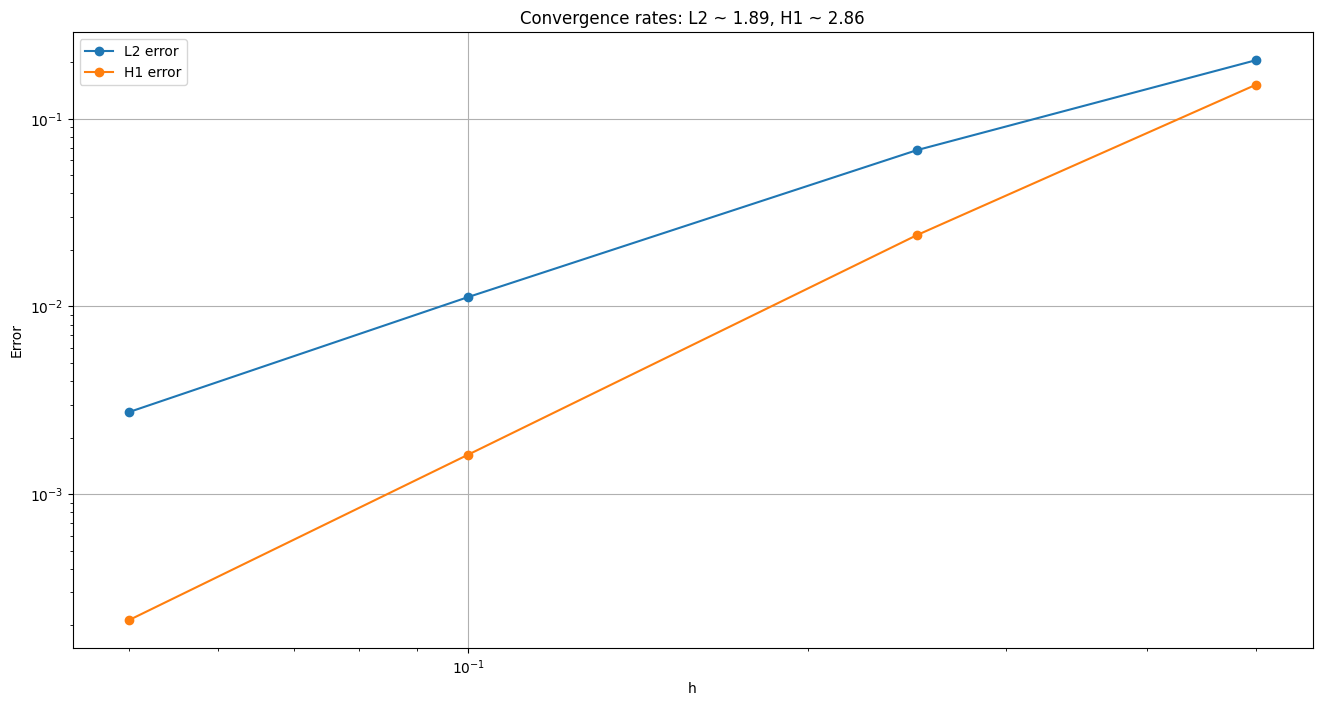

In [284]:
L2_errors = []
H1_errors = []
hs = []

for h in [0.5, 0.25, 0.1, 0.05]:  # refinement loop
    fem = HelmholtzNGSolveFEM(h=h)
    fem.generate_mesh(verbose=False)
    fem.instance_FESpace(p=1, complex=True, dirichlet_region='dirichlet')
    system_matrix, load_vec = fem.assemble_system(neuman_region='neumann')
    uh = fem.solve(A=system_matrix, F=load_vec, dirichlet_region='dirichlet')
    L2_err, H1_err = fem.compute_errors(sol=uh, H1=True)
    L2_errors.append(L2_err)
    H1_errors.append(H1_err)
    hs.append(h)
    print(f"h = {h:.5f} | L2 error = {L2_err:.3e}, H1 error = {H1_err:.3e}")

# Plot convergence
plt.figure(figsize=(16,8))
plt.loglog(hs, L2_errors, '-o', label='L2 error')
plt.loglog(hs, H1_errors, '-o', label='H1 error')

# Fit slopes
p_L2 = np.polyfit(np.log(hs), np.log(L2_errors), 1)[0]
p_H1 = np.polyfit(np.log(hs), np.log(H1_errors), 1)[0]
plt.legend()
plt.xlabel("h")
plt.ylabel("Error")
plt.title(f"Convergence rates: L2 ~ {p_L2:.2f}, H1 ~ {p_H1:.2f}")
plt.grid(True)
plt.show()
